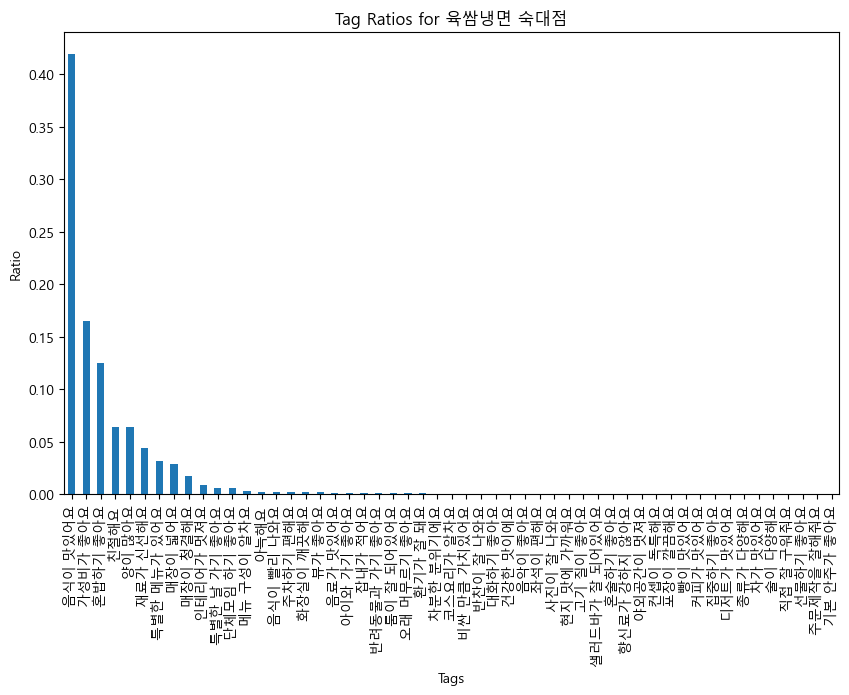

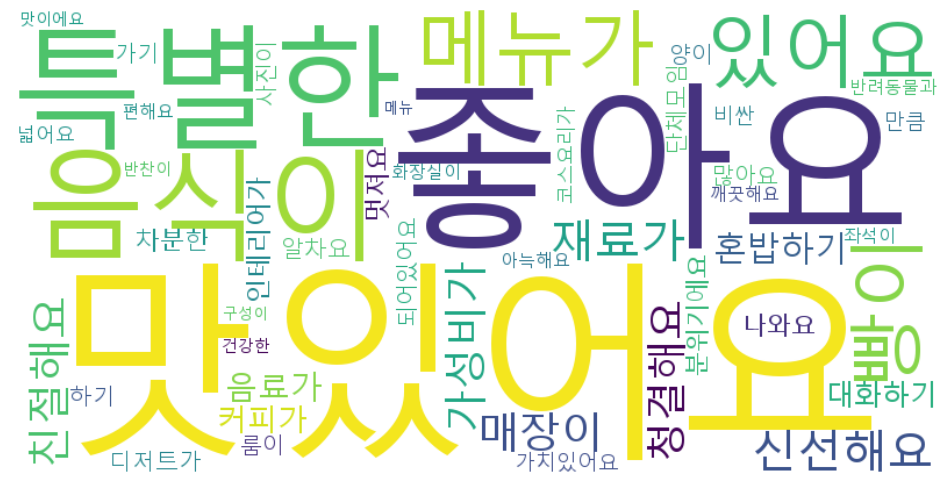

c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


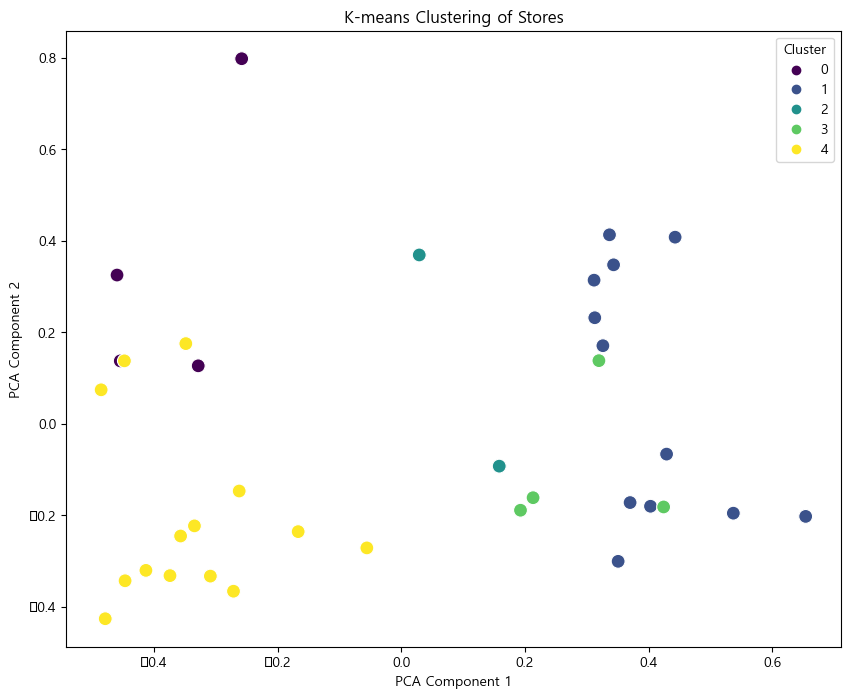

추천 가게 목록 (선호하지 않는 음식 제외, 상위 10%):
              가게명    음식종류  tag_ratio_sum
43         와플하우스      와플            1.0
3       포라임 숙대본점   베트남음식            1.0
26       몬스터플레이스  카페,디저트            1.0
17  마포구이마당 숙대직영점  돼지고기구이            1.0
31         부암동치킨  치킨,닭강정            1.0
23   미스터카츠 숙대입구점     돈가스            1.0
10        버스컵떡볶이     떡볶이            1.0
47         나폴리키친      피자            1.0
7      사이공마켓 숙대점   베트남음식            1.0


C:\Users\LG\AppData\Local\Temp\ipykernel_29768\1552748585.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_stores['tag_ratio_sum'] = filtered_stores['tag_ratios'].apply(lambda x: sum(x.values()))


In [1]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.decomposition import PCA
import matplotlib.font_manager as fm

# Step 1: 데이터 로드
# 첫 번째 파일: 가게별 태그와 태그 수
store_tags = pd.read_csv("C:\\dacos_rec\\crawling\\숙명여대_맛집_크롤링1.csv")
# 두 번째 파일: 가게별 리뷰 데이터
store_reviews = pd.read_csv("C:\\dacos_rec\\naver_review_2024-10-29_07-34-59 (2).csv")

# Step 2: 가게 태그 데이터 전처리 (store_tags)
# '태그리뷰' 열을 리스트로 변환하여 각 태그의 빈도를 계산
def process_tags(tag_list):
    tags = eval(tag_list)  # 문자열을 리스트로 변환
    total_count = sum(tag[next(iter(tag))] for tag in tags)  # 모든 태그의 합
    tag_freq = {list(tag.keys())[0].strip('{"}'): list(tag.values())[0] / total_count for tag in tags}
    return tag_freq

store_tags['tag_ratios'] = store_tags['태그리뷰'].apply(process_tags)

# 태그 비율 데이터프레임 생성
tag_ratio_df = store_tags['tag_ratios'].apply(pd.Series).fillna(0)
tag_ratio_df.index = store_tags['가게명']

# 한글 폰트 설정 (예: 맑은 고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 경로 지정
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# 특정 가게의 태그 비율 시각화 (예시로 첫 번째 가게)
selected_store = tag_ratio_df.iloc[0]
plt.figure(figsize=(10, 6))
selected_store.plot(kind='bar')
plt.title(f"Tag Ratios for {store_tags.iloc[0]['가게명']}")
plt.xlabel("Tags")
plt.ylabel("Ratio")
plt.show()

# Step 3: 리뷰 데이터 전처리 (store_reviews)
# 리뷰 키워드 열을 결합하여 TF-IDF를 적용할 수 있도록 전처리
store_reviews['combined_keywords'] = store_reviews[
    ['review_keyword_1', 'review_keyword_2', 'review_keyword_3', 'review_keyword_4', 'review_keyword_5']
].fillna('').agg(' '.join, axis=1)

# TF-IDF 벡터화
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(store_reviews['combined_keywords'])
tfidf_feature_names = tfidf.get_feature_names_out()

# 시각화 - TF-IDF 상위 키워드를 WordCloud로 표시
tfidf_scores = tfidf_matrix.toarray().sum(axis=0)
tfidf_keywords = dict(zip(tfidf_feature_names, tfidf_scores))

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(font_path=font_path, background_color='white', width=800, height=400).generate_from_frequencies(tfidf_keywords)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Step 4: 콘텐츠 기반 필터링 - 태그 비율과 TF-IDF 결합 행렬 생성
combined_matrix = hstack([tag_ratio_df.loc[store_reviews['store_name']].values, tfidf_matrix])

# 클러스터링 (KMeans)
kmeans = KMeans(n_clusters=5, random_state=0)
store_reviews['cluster'] = kmeans.fit_predict(combined_matrix)

# PCA로 2차원 축소
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(combined_matrix.toarray())

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_matrix[:, 0], y=pca_matrix[:, 1], hue=store_reviews['cluster'], palette="viridis", s=100)
plt.title("K-means Clustering of Stores")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Step 5: 필터링 기반 추천 함수
def filter_based_recommendation(user_unpreferred_types, store_tags, store_reviews):
    # 사용자가 선호하지 않는 음식 종류를 가진 가게 필터링
    filtered_stores = store_tags[~store_tags['음식종류'].isin(user_unpreferred_types)]
    filtered_store_names = filtered_stores['가게명']
    
    # 클러스터링 결과에서 유사한 가게를 추천
    recommendations = store_reviews[store_reviews['store_name'].isin(filtered_store_names)]
    return recommendations[['store_name', 'cluster']].drop_duplicates()

# Step 6: 사용자 기반 추천 함수 (사용자가 기존 리뷰를 남긴 경우)
def user_based_recommendation(user_reviews, user_id, store_reviews):
    user_cluster = user_reviews[user_reviews['user_id'] == user_id]['cluster'].values[0]
    recommended_stores = store_reviews[store_reviews['cluster'] == user_cluster]
    return recommended_stores[['store_name', 'cluster']].drop_duplicates()

# 음식 카테고리 선택과 필터링 기반 추천 함수
def filter_based_recommendation(selection):
    category_map = {1: '양식', 2: '중식', 3: '한식', 4: '일식', 5: '기타'}
    unpreferred_category = category_map.get(selection, None)
    
    if unpreferred_category:
        # 선택한 음식 종류를 포함하는 가게를 제외
        filtered_stores = store_tags[~store_tags['음식종류'].str.contains(unpreferred_category)]
        print("추천 가게 목록 (선호하지 않는 음식 제외):\n", filtered_stores[['가게명', '음식종류']])
    else:
        print("올바른 번호를 선택하세요.")

def filter_based_recommendation():
    # 임의로 선호하지 않는 음식 종류 설정
    unpreferred_categories = ['양식', '한식']  # 예시로 양식과 한식을 제외
    
    # 선택된 카테고리들을 포함하지 않는 가게만 필터링
    filtered_stores = store_tags[~store_tags['음식종류'].str.contains('|'.join(unpreferred_categories))]

    # 태그 비율 합산 기준으로 상위 10% 필터링
    filtered_stores['tag_ratio_sum'] = filtered_stores['tag_ratios'].apply(lambda x: sum(x.values()))
    filtered_stores = filtered_stores.sort_values(by='tag_ratio_sum', ascending=False)
    top_10_percent_index = int(len(filtered_stores) * 0.1) or 1  # 상위 10% 계산 (최소 1개 이상)

    # 상위 10% 추천 가게 목록
    top_10_percent_stores = filtered_stores.head(top_10_percent_index)
    print("추천 가게 목록 (선호하지 않는 음식 제외, 상위 10%):\n", top_10_percent_stores[['가게명', '음식종류', 'tag_ratio_sum']])

# 함수 실행
filter_based_recommendation()



# 2. 특정 사용자의 기존 리뷰 기반 추천 (가상의 user_reviews 데이터가 필요합니다)
# user_based_recommendations = user_based_recommendation(user_reviews, 'user123', store_reviews)
# print("User-based Recommendations based on past reviews:\n", user_based_recommendations)
